# Ant Colony Optimization - Travelling Salesman Problem

## Preparing Data

In [1]:
%matplotlib inline
import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import random

random.seed(42)

In [2]:
map_image = mpimg.imread("map.png")  # US States & Capitals map

with open('capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)
    
capitals_list = list(capitals.items())
capitals_list = [(c[0], tuple(c[1])) for c in capitals_list]
def show_path(path, starting_city, w=12, h=8):
    x, y = list(zip(*path))
    _, (x0, y0) = starting_city
    plt.imshow(map_image)
    plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

In [3]:
def path_cost(path):
  c = 0
  for i, node in enumerate(path[:-1]):
    next_node = path[i + 1]
    c += np.sqrt((next_node[0] - node[0])**2 + (next_node[1] - node[1]) ** 2)
  c += np.sqrt((path[0][0] - path[-1][0]) ** 2 + (path[0][1] - path[-1][0]) ** 2)
  return c

[('Atlanta', (585.6, 376.8)), ('Des Moines', (447.6, 246.0)), ('Salem', (80.0, 139.2)), ('Tallahassee', (594.8, 434.8)), ('Nashville', (546.4, 336.8)), ('Austin', (389.2, 448.4)), ('Columbus', (590.8, 263.2)), ('Richmond', (673.2, 293.6))]
Initial path value: 2139.31


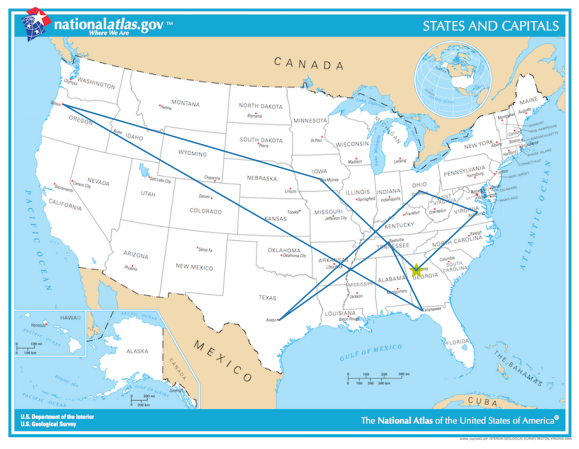

In [4]:
num_cities = 8
random.shuffle(capitals_list) # set seed to get the same result every time
active_cities = capitals_list[:num_cities]
starting_city = active_cities[0]
points = [city[1] for city in active_cities]
show_path(points, starting_city)
print(active_cities)
print("Initial path value: {:.2f}".format(path_cost(points)))

In [5]:
space = np.array(points)
space

array([[585.6, 376.8],
       [447.6, 246. ],
       [ 80. , 139.2],
       [594.8, 434.8],
       [546.4, 336.8],
       [389.2, 448.4],
       [590.8, 263.2],
       [673.2, 293.6]])

## Algorithm

In [6]:
def init_ants(space, colony):
    init_pos = np.random.randint(space.shape[0], size=colony)
    return init_pos

In [7]:
def find_inv_distance(space, beta):
    distances = np.zeros((space.shape[0], space.shape[0]))
    for index, point in enumerate(space):
        distances[index] = np.sqrt(((space - point) ** 2).sum(axis=1))
    with np.errstate(all='ignore'):
        inv_distance =  1 / distances
    inv_distance[inv_distance == np.inf] = 0
    return inv_distance ** beta

In [8]:
def ants_move(space, pos, inv_distance, pheromones, alpha, beta, del_tau):
    paths = np.zeros((space.shape[0], pos.shape[0]), dtype=int) - 1
    paths[0] = pos
    for node in range(1, space.shape[0]):
        for ant in range(pos.shape[0]):
            next_loc_prob = (inv_distance[pos[ant]] ** alpha + pheromones[pos[ant]] ** beta / 
                                inv_distance[pos[ant]].sum() ** alpha + pheromones[pos[ant]].sum() ** beta)
            next_pos = np.argwhere(next_loc_prob == np.amax(next_loc_prob))[0][0]

            while next_pos in paths[:, ant]:
                next_loc_prob[next_pos] = 0.0
                next_pos = np.argwhere(next_loc_prob == np.amax(next_loc_prob))[0][0]
            paths[node, ant] = next_pos
            pheromones[node, next_pos] = pheromones[node, next_pos] + del_tau
    return np.swapaxes(paths, 0, 1)

In [9]:
def aco(space, iters=50, colony=25, alpha=1.0, beta=1.0, del_tau=0.5, rho=0.5):
    inv_distance = find_inv_distance(space, beta)
    pheromones = np.zeros((space.shape[0], space.shape[0]))
    min_distance = None
    min_path = None
    for i in range(iters):
        init_pos = init_ants(space, colony)
        paths = ants_move(space, init_pos, inv_distance, pheromones, alpha, beta, del_tau)
        pheromones *= (1 - rho)
        
        for path in paths:
            distance = 0
            for node in range(1, path.shape[0]):
                distance += np.sqrt(((space[int(path[node])] - space[int(path[node-1])]) ** 2).sum())
            distance += np.sqrt(((space[int(path[0])] - space[int(path[-1])]) ** 2).sum())

            if not min_distance or distance < min_distance:
                min_distance = distance
                min_path = path

    min_path = np.append(min_path, min_path[0])
    return (min_path, min_distance)

[('Richmond', (673.2, 293.6)), ('Tallahassee', (594.8, 434.8)), ('Austin', (389.2, 448.4)), ('Salem', (80.0, 139.2)), ('Des Moines', (447.6, 246.0)), ('Columbus', (590.8, 263.2)), ('Nashville', (546.4, 336.8)), ('Atlanta', (585.6, 376.8)), ('Richmond', (673.2, 293.6))]
Minimum distance is: 1594.6339944826411
CPU times: user 3.63 s, sys: 224 ms, total: 3.85 s
Wall time: 4.49 s


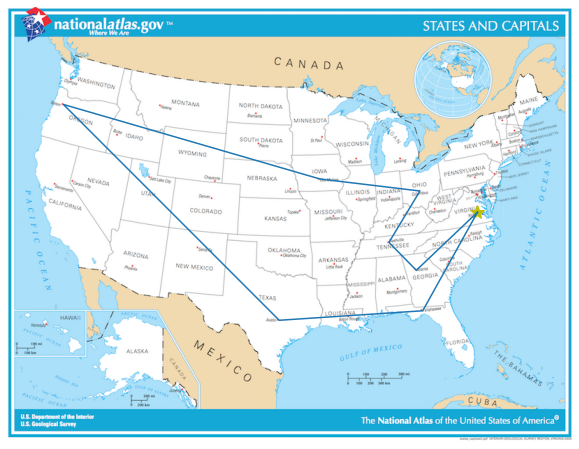

In [10]:
%%time
min_path, min_distance = aco(space, 100, 30, 1, 0.5, 1, 0.5)

path = [active_cities[i] for i in min_path.tolist()]
print(path)
print("Minimum distance is: {}".format(min_distance))
show_path([p[1] for p in path], path[0])